In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download --force -d destrasaevianda/capstonekita

100% 140M/140M [00:01<00:00, 138MB/s]
100% 140M/140M [00:01<00:00, 106MB/s]


In [ ]:
!unzip capstonekita.zip

Archive:  capstonekita.zip
  inflating: dataset/Bus/1.jpg       
  inflating: dataset/Bus/2.jpg       
  inflating: dataset/Bus/3.jpg       
  inflating: dataset/Bus/4.jpg       
  inflating: dataset/Bus/5.jpg       
  inflating: dataset/Bus/Image_1.jpg  
  inflating: dataset/Bus/Image_10.jpg  
  inflating: dataset/Bus/Image_11.jpg  
  inflating: dataset/Bus/Image_12.jpg  
  inflating: dataset/Bus/Image_13.jpg  
  inflating: dataset/Bus/Image_14.jpg  
  inflating: dataset/Bus/Image_15.jpg  
  inflating: dataset/Bus/Image_16.jpg  
  inflating: dataset/Bus/Image_17.jpg  
  inflating: dataset/Bus/Image_18.jpg  
  inflating: dataset/Bus/Image_19.jpg  
  inflating: dataset/Bus/Image_2.jpg  
  inflating: dataset/Bus/Image_20.jpg  
  inflating: dataset/Bus/Image_21.jpg  
  inflating: dataset/Bus/Image_22.jpg  
  inflating: dataset/Bus/Image_23.jpg  
  inflating: dataset/Bus/Image_24.png  
  inflating: dataset/Bus/Image_25.png  
  inflating: dataset/Bus/Image_26.jpg  
  inflating: dataset/Bus/

In [ ]:
import os
Dataset = './dataset'
labels = sorted(os.listdir(Dataset))
labels

['Bus', 'Hatchback', 'MVP-SUV', 'Motorcycle', 'Pickup', 'Sedan', 'Truck']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/valset.zip'
extract_path = '/content/valset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os
valset = '/content/valset/'
labels = sorted(os.listdir(valset))
labels

['Bus', 'Hatchback', 'MVP-SUV', 'Motorcycle', 'Pickup', 'Sedan', 'Truck']

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2
import imghdr
import shutil

In [ ]:
image_directory = '/content/dataset'
compatible_extns = ['png', 'jpg', 'jpeg', 'JPG']

for image_class in os.listdir(image_directory):
    for image in os.listdir(os.path.join(image_directory, image_class)):
        image_path = os.path.join(image_directory, image_class, image)
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in compatible_extns:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)

Image not in ext list /content/dataset/Sedan/sedan1.webp


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.1
)
train_generator = image_datagen.flow_from_directory(
    image_directory,
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    subset="training",
    class_mode='categorical'
)

valid_generator = image_datagen.flow_from_directory(
    image_directory,
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    subset="validation",
    class_mode='categorical'
)

Found 538 images belonging to 7 classes.
Found 56 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'Bus': 0,
 'Hatchback': 1,
 'MVP-SUV': 2,
 'Motorcycle': 3,
 'Pickup': 4,
 'Sedan': 5,
 'Truck': 6}

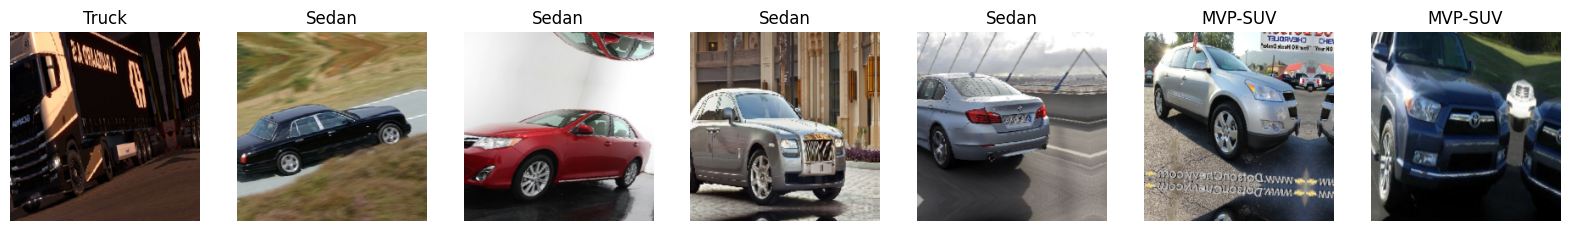

In [ ]:
import numpy as np
import pandas as pd

model_dict = train_generator.class_indices
model_dict_as_list = list(model_dict.keys())
train_imgs, labels = train_generator.next()

fig, ax = plt.subplots(ncols = 7, figsize = (20,20))
for i_img in range (7):
    ax[i_img].imshow(train_imgs[i_img])
    ax[i_img].title.set_text(model_dict_as_list[np.argmax(labels[i_img])])
    ax[i_img].axis('off')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

inception_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in inception_model.layers[:-8]:
    layer.trainable = True

car_recog_model = tf.keras.models.Sequential([
    inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')
])

car_recog_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Adjust the learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

car_recog_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.85) and (
                logs.get('accuracy') is not None and logs.get('accuracy') > 0.85):
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [ ]:
hist = car_recog_model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[tensorboard_callback, accuracy_callback]
)

Epoch 1/100
17/17 [==============================] - 44s 863ms/step - loss: 15.5352 - accuracy: 0.1394 - val_loss: 15.2559 - val_accuracy: 0.2321
Epoch 2/100
17/17 [==============================] - 14s 835ms/step - loss: 15.3726 - accuracy: 0.1524 - val_loss: 15.1537 - val_accuracy: 0.2143
Epoch 3/100
17/17 [==============================] - 14s 832ms/step - loss: 15.2540 - accuracy: 0.1784 - val_loss: 14.9933 - val_accuracy: 0.2143
Epoch 4/100
17/17 [==============================] - 16s 919ms/step - loss: 15.1664 - accuracy: 0.1989 - val_loss: 14.8833 - val_accuracy: 0.3750
Epoch 5/100
17/17 [==============================] - 13s 757ms/step - loss: 15.0652 - accuracy: 0.2305 - val_loss: 14.8497 - val_accuracy: 0.3750
Epoch 6/100
17/17 [==============================] - 14s 831ms/step - loss: 15.0547 - accuracy: 0.2026 - val_loss: 14.7879 - val_accuracy: 0.4107
Epoch 7/100
17/17 [==============================] - 14s 826ms/step - loss: 14.9585 - accuracy: 0.2546 - val_loss: 14.7148 -

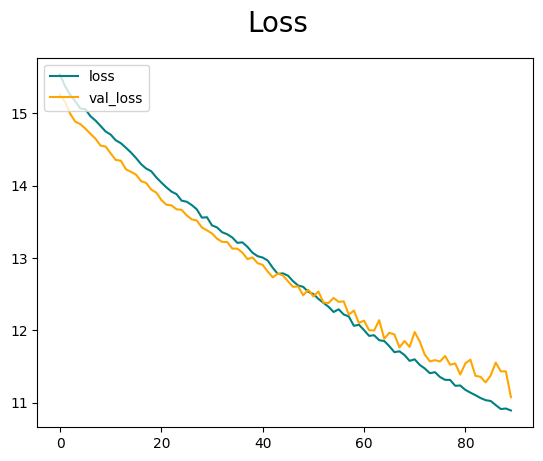

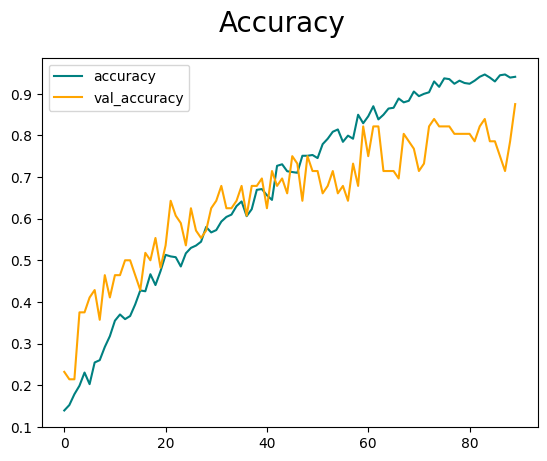

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
val_loss, val_accuracy = car_recog_model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

2/2 [==============================] - 1s 579ms/step - loss: 11.1411 - accuracy: 0.8750
Validation Accuracy: 87.50%


In [ ]:
car_recog_model.save('/content/drive/MyDrive/car_recog_incepv3.h5')
print(f'Model saved to: /content/drive/MyDrive/car_recog_incepv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /content/drive/MyDrive/car_recog_incepv3.h5


In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(car_recog_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/drive/MyDrive/car_recog_incepv3.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {'/content/drive/MyDrive/car_recog_incepv3.tflite'}")

TensorFlow Lite model saved to /content/drive/MyDrive/car_recog_incepv3.tflite


/content/valset/MVP-SUV/19.jpg


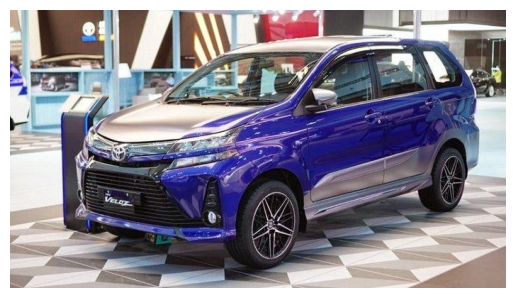

In [ ]:
import cv2
import random
from PIL import Image

# Will pick random image and check
test_folders = os.listdir("/content/valset")
random_folder = random.choice(test_folders)
path = os.path.join("/content/valset", random_folder)
random_image_path = random.choice(os.listdir(os.path.join("/content/valset", random_folder)))
random_image = os.path.join("/content/valset", random_folder, random_image_path)
print(random_image)
img = cv2.imread(random_image)
plt.imshow(img)
plt.axis('off')
plt.show() # image will have weird colours because cv2 uses grb scheme.

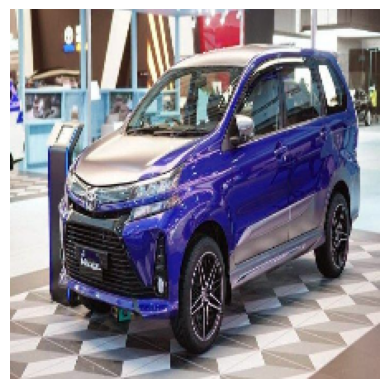

In [ ]:
resize_img = tf.image.resize(img, (224,224))
plt.imshow(resize_img.numpy().astype(int))
plt.axis('off')
plt.show()

In [ ]:
model_prediction = car_recog_model.predict(np.expand_dims(resize_img/255, 0))
prediction = np.argmax(model_prediction)

class_names = train_generator.class_indices

for class_label, class_index in class_names.items():
    if class_index == prediction:
        predicted_class_name = class_label

print(predicted_class_name)
print(model_prediction)

1/1 [==============================] - 0s 27ms/step
MVP-SUV
[[7.3391362e-04 6.1924439e-03 9.8324573e-01 9.1309589e-04 4.8500933e-03
  2.8415781e-03 1.2231043e-03]]
